# SINGGALANG Dataset Preprocessing and Oversampling

This notebook loads `data/SINGGALANG.tsv`, inspects class balance, and shows two oversampling approaches: `RandomOverSampler` and `SMOTE` (from `imbalanced-learn`). The oversampled dataset is saved to `data/SINGGALANG_oversampled.tsv`.

In [2]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
print('Libraries imported')

Libraries imported


In [3]:
# Load dataset (TSV) - robust to common parser errors (EOF inside string)
import csv
path = 'data/SINGGALANG.tsv'
# First try the fast C engine
try:
    df = pd.read_csv(path, sep='	', engine='c', low_memory=False)
    print('Loaded with C engine, shape:', df.shape)
except Exception as e:
    print('C engine failed with:', repr(e))
    print('Retrying with python engine and relaxed quoting (treat quotes as regular characters)')
    # Treat quotes as normal characters to avoid EOF-inside-string errors caused by unmatched quotes
    # Note: low_memory is not supported with python engine, so we omit it
    df = pd.read_csv(path, sep='	', engine='python', quoting=csv.QUOTE_NONE, escapechar='\\', on_bad_lines='skip')
    print('Loaded with python engine fallback, shape:', df.shape)
display(df.head())
# Determine target/label column: prefer common names, otherwise use last column
candidates = ['label','Label','target','class','CLASS','y']
target_col = None
for c in candidates:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    # fall back to last column
    target_col = df.columns[-1]
print('Detected target column:', target_col)
print('Class distribution:')
print(Counter(df[target_col]))

C engine failed with: ParserError('Error tokenizing data. C error: EOF inside string starting at row 712938')
Retrying with python engine and relaxed quoting (treat quotes as regular characters)
Loaded with python engine fallback, shape: (1478267, 2)
Loaded with python engine fallback, shape: (1478267, 2)


,Ia,O
0,menjabat,O
1,sebagai,O
2,Presiden,O
3,ketiga,O
4,Mesir,Place


Detected target column: O
Class distribution:
Counter({'O': 1340022, 'Place': 82178, 'Person': 41297, 'Organisation': 14770})


In [4]:
# Oversampling with RandomOverSampler (safe for numeric and categorical encoded data)
# Install imbalanced-learn if needed: !pip install -q imbalanced-learn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
# Prepare X and y - keep all other columns as features
X = df.drop(columns=[target_col])
y = df[target_col]
print('Feature shape:', X.shape)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('After RandomOverSampler, shapes:', X_res.shape, y_res.shape)
from collections import Counter
print('New class distribution:', Counter(y_res))
# Reconstruct a dataframe and save
df_res = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name=target_col)], axis=1)
out_path = 'data/SINGGALANG_oversampled.tsv'
df_res.to_csv(out_path, sep='	', index=False)
print('Saved oversampled dataset to', out_path)

Feature shape: (1478267, 1)
After RandomOverSampler, shapes: (5360088, 1) (5360088,)
New class distribution: Counter({'O': 1340022, 'Place': 1340022, 'Person': 1340022, 'Organisation': 1340022})
After RandomOverSampler, shapes: (5360088, 1) (5360088,)
New class distribution: Counter({'O': 1340022, 'Place': 1340022, 'Person': 1340022, 'Organisation': 1340022})
Saved oversampled dataset to data/SINGGALANG_oversampled.tsv
Saved oversampled dataset to data/SINGGALANG_oversampled.tsv


Perbandingan distribusi kelas:
              original  oversampled
O                                  
O              1340022      1340022
Organisation     14770      1340022
Person           41297      1340022
Place            82178      1340022



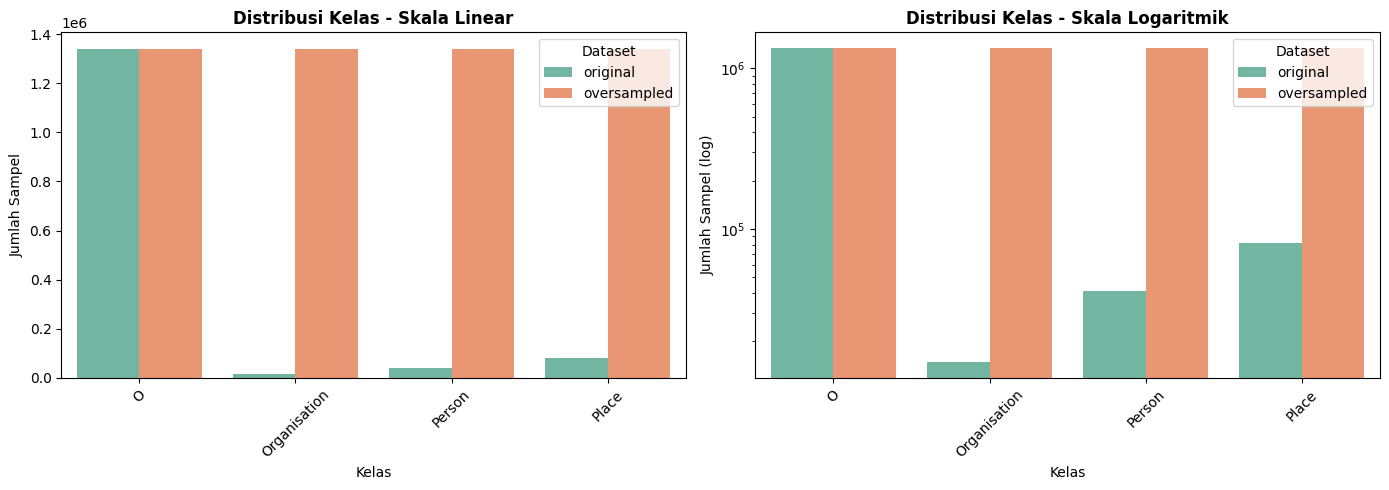


✓ Oversampling berhasil!
  Dataset asli: 1478267 sampel
  Dataset hasil oversampling: 5360088 sampel
  Penambahan: 3,881,821 sampel


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung distribusi kelas sebelum dan sesudah oversampling
orig_counts = y.value_counts().sort_index()
res_counts = y_res.value_counts().sort_index()

# Buat dataframe perbandingan
comp = pd.concat([orig_counts.rename('original'), res_counts.rename('oversampled')], axis=1).fillna(0).astype(int)
print('Perbandingan distribusi kelas:')
print(comp)
print()

# Siapkan data untuk visualisasi
comp_reset = comp.reset_index().rename(columns={target_col: 'class'})
melt_data = comp_reset.melt(id_vars='class', value_vars=['original', 'oversampled'],
                            var_name='dataset', value_name='count')

# Buat plot perbandingan: linear dan log scale
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot 1: Skala linear
sns.barplot(data=melt_data, x='class', y='count', hue='dataset', ax=axes[0], palette='Set2')
axes[0].set_title('Distribusi Kelas - Skala Linear', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Dataset')

# Plot 2: Skala logaritmik (untuk melihat kelas minor lebih jelas)
sns.barplot(data=melt_data, x='class', y='count', hue='dataset', ax=axes[1], palette='Set2')
axes[1].set_yscale('log')
axes[1].set_title('Distribusi Kelas - Skala Logaritmik', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Jumlah Sampel (log)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()

print('\n✓ Oversampling berhasil!')
print(f'  Dataset asli: {len(y)} sampel')
print(f'  Dataset hasil oversampling: {len(y_res)} sampel')
print(f'  Penambahan: {len(y_res) - len(y):,} sampel')

In [ ]:
# Optional: SMOTE example (for numeric feature spaces)
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_sm, y_sm = sm.fit_resample(X, y)
# print('After SMOTE distribution:', Counter(y_sm))
# df_sm = pd.concat([pd.DataFrame(X_sm, columns=X.columns), pd.Series(y_sm, name=target_col)], axis=1)
# df_sm.to_csv('data/SINGGALANG_smote.tsv', sep='	', index=False)
# print('Saved SMOTE oversampled dataset to data/SINGGALANG_smote.tsv')
pass

**Install and Run**:
- In PowerShell, run: `pip install -U pandas scikit-learn imbalanced-learn`
- Open this notebook and run cells sequentially. The oversampled file will be saved to `data/SINGGALANG_oversampled.tsv`.
- If your features include categorical strings, encode them (e.g., `pd.get_dummies` or `sklearn.preprocessing.OrdinalEncoder`) before SMOTE. `RandomOverSampler` can duplicate samples as-is.